In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
import keras

from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot, plot_dist, plot_hexagon_grid

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt


seed = 360

from datasets import make_data, train_val_test_split, tensorflow_dataset
from models import poisson_glm
from metrics import poisson_nll, get_bpr_loss_func, get_penalized_bpr_loss_func, top_k_idx


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# tracts/distributions
S=12
# history/features
H = 50
# total timepoints
T= 500
# K for bpr
K=3


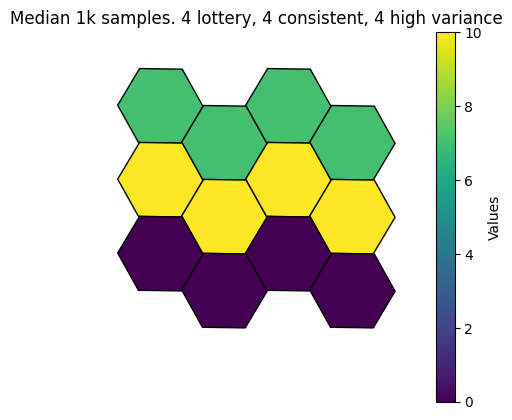

In [22]:
consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_4 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 1-0.7) for _ in range(4)]

powerball_4 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(4)]
dist_S = consistent_4 + highvar_4 +powerball_4

sample_and_plot(dist_S, size=1000, median=True, title='Median 1k samples. 4 lottery, 4 consistent, 4 high variance')

In [23]:

X_THS, y_TS = make_data(dist_S, H=H, T=T, seed=360)

# check that each final history is equal to the previous observation
for t in range(H, T):
    assert(np.all(X_THS[t, H-1, :] == y_TS[t-1, :]))

# check random point in history
for t in range(H, T):
    h = np.random.randint(0, H)
    assert(np.all(X_THS[t, h, :] == y_TS[t-(H-h), :]))

(train_X_THS, train_y_TS), \
(val_X_THS, val_y_TS), \
(test_X_THS, test_y_TS) = train_val_test_split(X_THS, y_TS, train_pct=0.6, test_pct=0.2)

train_dataset = tensorflow_dataset(train_X_THS, train_y_TS, seed=seed+200,batch_size=100)
val_dataset = tensorflow_dataset(val_X_THS, val_y_TS, seed=seed+300,batch_size=100)

In [24]:
model = poisson_glm(input_shape=(H,S), seed=seed+175)

In [25]:
preds_TS = model.predict(X_THS)
my_poisson_nll = poisson_nll(y_TS, preds_TS).numpy()
tf_poisson_nll = tf.nn.log_poisson_loss(targets=y_TS, log_input=tf.math.log(preds_TS+ 1e-10), compute_full_loss=True).numpy()
assert(np.allclose(my_poisson_nll, tf_poisson_nll, atol=1e-9))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


AttributeError: 'str' object has no attribute 'numpy'

In [26]:
tf_poisson_nll[0]

array([9.5543808e+01, 9.5543808e+01, 9.5543808e+01, 9.5543808e+01,
       2.3247689e-05, 1.3461285e+02, 1.5955553e+02, 9.5225786e-08,
       9.9999876e-11, 8.1774307e+01, 1.0029997e-10, 2.2822400e+03],
      dtype=float32)

In [27]:
my_poisson_nll[0]

array([  81.733    ,   81.733    ,   81.733    ,   81.733    ,
         -4.4156933,  114.45987  ,  138.15532  ,   -7.165095 ,
        -39.537685 ,   84.89523  ,  -13.498667 , 1909.817    ],
      dtype=float32)

In [29]:
penalty = 500
bpr_threshold = 0.45

negative_bpr_K = get_bpr_loss_func(K)
penalized_bpr_loss = get_penalized_bpr_loss_func(tf.nn.log_poisson_loss, K, penalty, bpr_threshold)
optimizer = keras.optimizers.Adam(learning_rate=0.005)

In [154]:
model.compile(optimizer=optimizer, loss=penalized_bpr_loss, metrics = [poisson_nll, negative_bpr_K])

In [155]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=1000, verbose=1)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3/3 [==============================] - 1s 260ms/step - loss: 140.6820 - poisson_nll: 86.3636 - partial: -0.3409 - val_loss: 128.8245 - val_poisson_nll: 70.6732 - val_partial: -0.3328
Epoch 2/1000
3/3 [==============================] - 0s 130ms/step - loss: 116.5729 - poisson_nll: 64.8447 - par

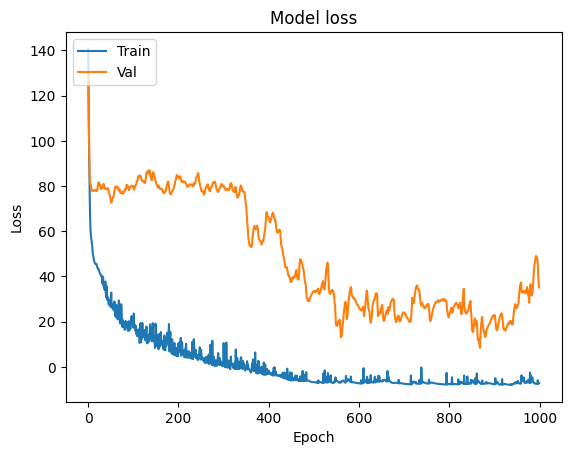

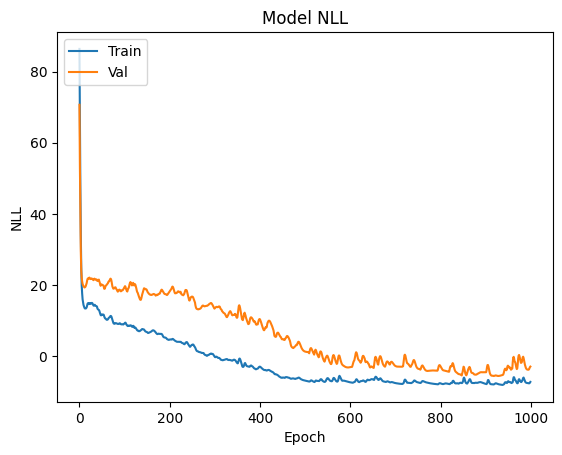

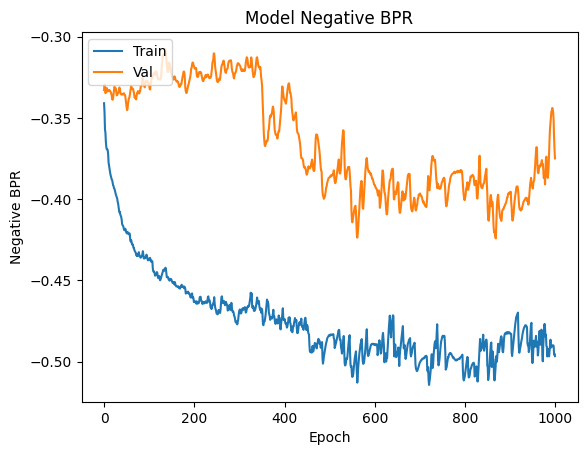

In [156]:
# plot loss and metrics from history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['poisson_nll'])
plt.plot(history.history['val_poisson_nll'])
plt.title('Model NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history['partial'])
plt.plot(history.history['val_partial'])
plt.title('Model Negative BPR')
plt.ylabel('Negative BPR')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [157]:
from functools import partial
val_preds = model.predict(val_X_THS)
# get one hot vector of top 3 values in val_preds
top_K_idx_func = partial(top_k_idx, k=K)
top_K_ids = top_K_idx_func(val_preds)
np.mean(top_K_ids, axis=0)

4/4 [==============================] - 0s 2ms/step


array([0.14, 0.02, 0.  , 0.  , 0.3 , 0.36, 0.42, 0.32, 0.37, 0.39, 0.35,
       0.33], dtype=float32)

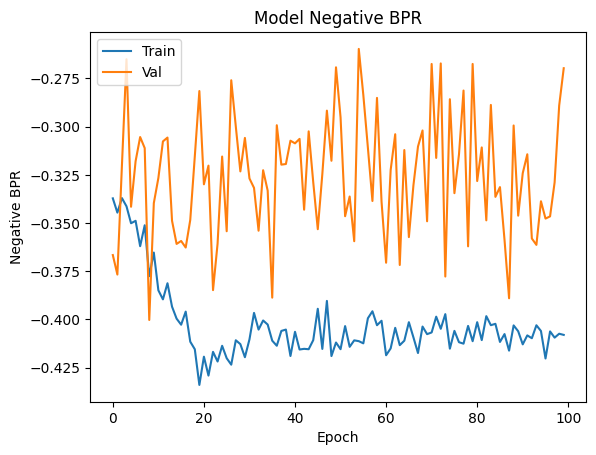

In [90]:
# plot loss and metrics from history
plt.plot(history.history['partial'])
plt.plot(history.history['val_partial'])
plt.title('Model Negative BPR')
plt.ylabel('Negative BPR')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


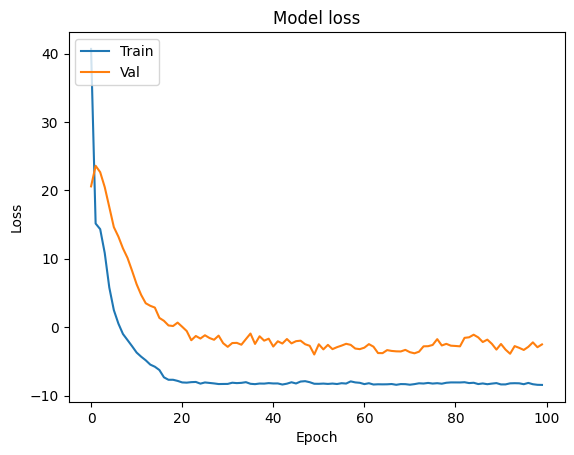

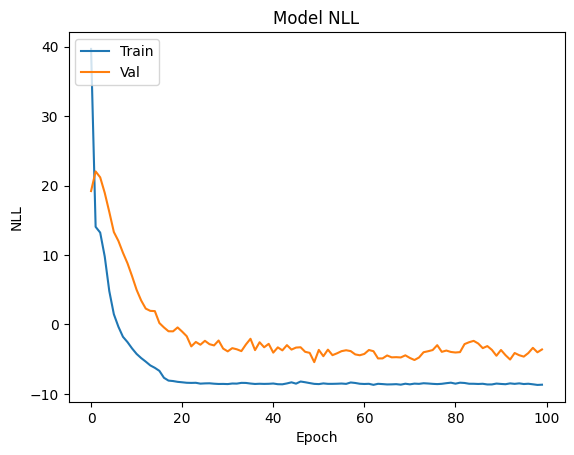

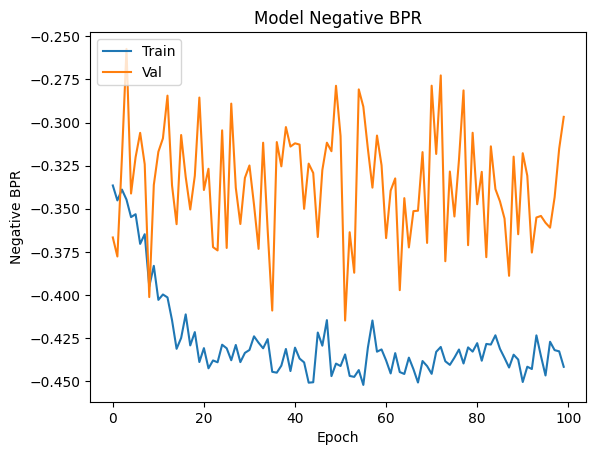

In [122]:
history.history.keys()

dict_keys(['loss', 'poisson_nll', 'partial', 'val_loss', 'val_poisson_nll', 'val_partial'])